# Análise Exploratória do Dataset de Sutura Cirúrgica

Este notebook fornece uma visão geral do dataset utilizado para o desafio 'OSS: Open Suturing Skills' da Endoscopic Vision Challenge 2025. Vamos explorar a estrutura dos dados, entender o formato dos vídeos e analisar as informações disponíveis.

## Objetivos
- Entender a estrutura do dataset
- Analisar os formatos de vídeo disponíveis
- Explorar metadados associados (se disponíveis)
- Visualizar exemplos de frames dos vídeos

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_palette('muted')
%matplotlib inline

## 1. Estrutura do Dataset

Vamos começar explorando a estrutura de pastas e arquivos do dataset.

In [2]:
dataset_path = '../../dataset'

video_files = glob.glob(os.path.join(dataset_path, '**/*.mp4'), recursive=True)

print(f'Total de vídeos encontrados: {len(video_files)}')

# Mostrar os primeiros 5 ficheiros
for i, video_file in enumerate(video_files[:5]):
    print(f'{i+1}. {os.path.relpath(video_file, dataset_path)}')

folders = set([os.path.dirname(os.path.relpath(file, dataset_path)) for file in video_files])
print('\nEstrutura de pastas:')
for folder in sorted(folders):
    print(f'- {folder}')

Total de vídeos encontrados: 30
1. A88O.mp4
2. A80U.mp4
3. A40E.mp4
4. A99X.mp4
5. B12G.mp4

Estrutura de pastas:
- 


## 2. Análise de Nomenclatura

Vamos analisar os padrões de nomenclatura dos arquivos para entender se há alguma convenção ou informação codificada nos nomes.

In [3]:
filenames = [os.path.basename(file) for file in video_files]

filename_patterns = pd.Series(filenames).str.extract(r'([\w-]+)_?(\d*)\.(\w+)')
filename_patterns.columns = ['prefix', 'number', 'extension']

print('Padrões de nomenclatura:')
print(filename_patterns['prefix'].value_counts())

print('\nExtensões de arquivo:')
print(filename_patterns['extension'].value_counts())

Padrões de nomenclatura:
prefix
A88O    1
A80U    1
B61D    1
C58C    1
B68G    1
B36R    1
B88L    1
C48S    1
A41X    1
A59Z    1
A99Y    1
C33I    1
A61V    1
A36O    1
B53D    1
A92O    1
A66S    1
A31H    1
C36X    1
C56Y    1
C42I    1
C46R    1
C43T    1
C28D    1
A83X    1
C16G    1
B12G    1
A99X    1
A40E    1
C18X    1
Name: count, dtype: int64

Extensões de arquivo:
extension
mp4    30
Name: count, dtype: int64


## 3. Visualização de Exemplos

Vamos visualizar alguns frames de exemplo dos vídeos para entender melhor o conteúdo.

A analisar o vídeo: A88O.mp4
Informações do vídeo:
- Resolução: 1920x1080
- Total de frames: 9597
- FPS: 29.97
- Duração: 320.19 segundos


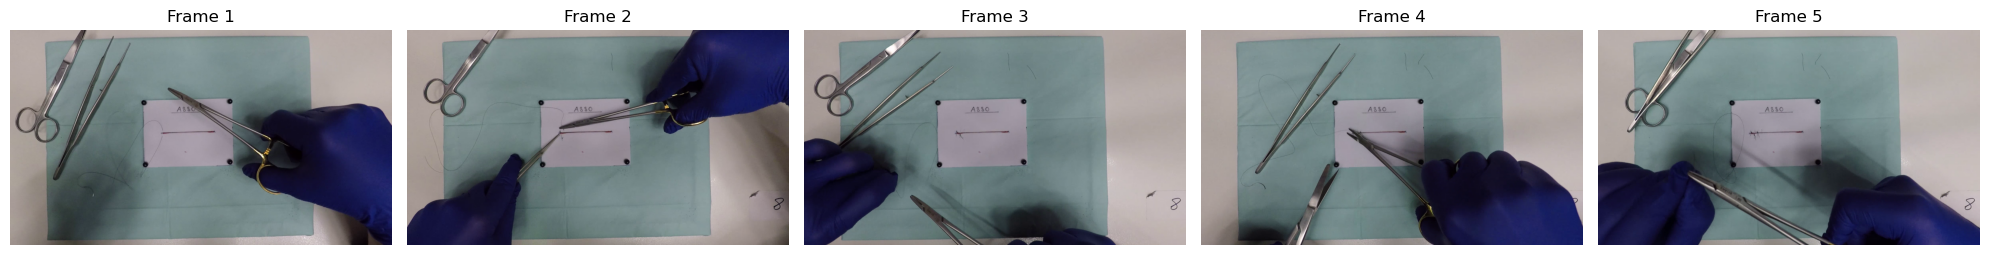

In [4]:
def extract_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f'Erro ao abrir o vídeo: {video_path}')
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print('Informações do vídeo:')
    print(f'- Resolução: {width}x{height}')
    print(f'- Total de frames: {total_frames}')
    print(f'- FPS: {fps:.2f}')
    print(f'- Duração: {duration:.2f} segundos')

    if total_frames <= num_frames:
        frame_indices = list(range(total_frames))
    else:
        frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

    cap.release()
    return frames

if video_files:
    sample_video = video_files[0]
    print(f'A analisar o vídeo: {os.path.basename(sample_video)}')
    frames = extract_frames(sample_video, num_frames=5)

    if frames:
        fig, axes = plt.subplots(1, len(frames), figsize=(20, 4))
        for i, frame in enumerate(frames):
            axes[i].imshow(frame)
            axes[i].set_title(f'Frame {i+1}')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print('Não foi possível extrair frames do vídeo.')
else:
    print('Nenhum vídeo encontrado no dataset.')

## 4. Análise de Conteúdo

Vamos analisar o conteúdo dos vídeos para identificar padrões e características relevantes para as tarefas de segmentação temporal e detecção de erros.

A analisar conteúdo do vídeo: A88O.mp4


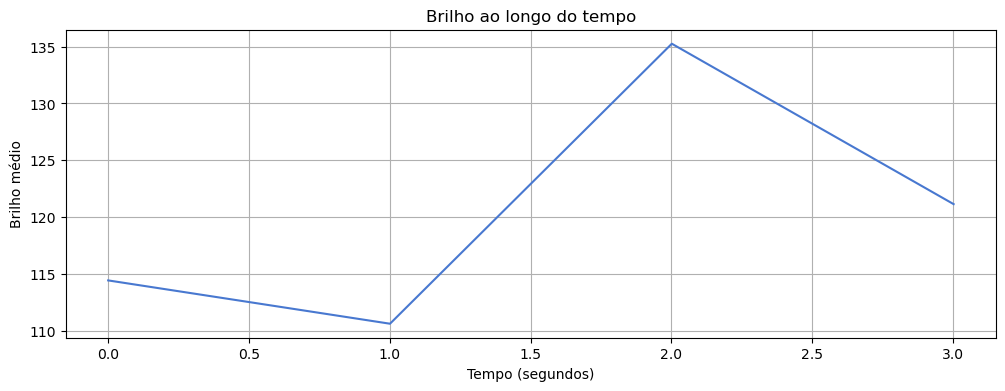

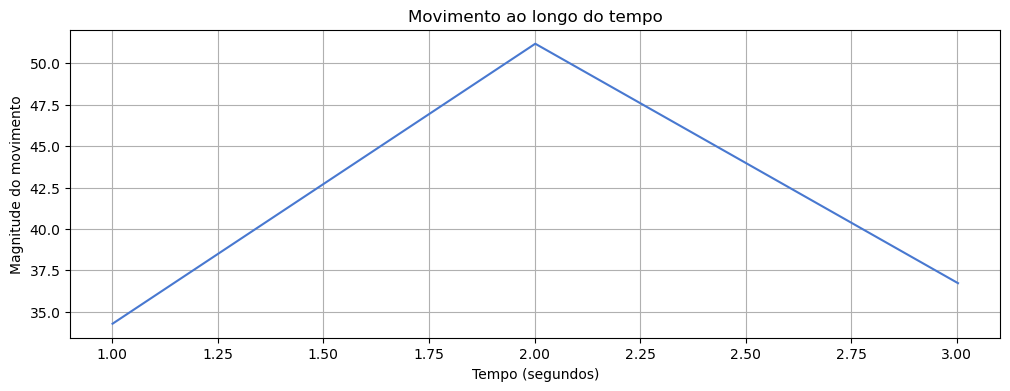

In [5]:
def analyze_video_content(video_path, sample_rate=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f'Erro ao abrir o vídeo: {video_path}')
        return {}

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    brightness_values = []
    motion_values = []
    prev_frame = None
    timestamps = []

    for i in range(0, total_frames, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        brightness_values.append(brightness)
        timestamps.append(i / fps if fps > 0 else 0)
        if prev_frame is not None:
            motion = np.mean(cv2.absdiff(gray, prev_frame))
            motion_values.append(motion)
        prev_frame = gray

    cap.release()
    return {
        'brightness': brightness_values,
        'motion': motion_values,
        'timestamps': timestamps
    }

if video_files:
    sample_video = video_files[0]
    print(f'A analisar conteúdo do vídeo: {os.path.basename(sample_video)}')
    analysis = analyze_video_content(sample_video)

    if analysis:
        plt.figure(figsize=(12, 4))
        plt.plot(analysis['timestamps'], analysis['brightness'])
        plt.title('Brilho ao longo do tempo')
        plt.xlabel('Tempo (segundos)')
        plt.ylabel('Brilho médio')
        plt.grid(True)
        plt.show()

        if analysis['motion']:
            plt.figure(figsize=(12, 4))
            plt.plot(analysis['timestamps'][1:], analysis['motion'])
            plt.title('Movimento ao longo do tempo')
            plt.xlabel('Tempo (segundos)')
            plt.ylabel('Magnitude do movimento')
            plt.grid(True)
            plt.show()
    else:
        print('Não foi possível analisar o conteúdo do vídeo.')
else:
    print('Nenhum vídeo encontrado no dataset.')